In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from matplotlib import rcParams
rcParams['figure.figsize'] = (15, 10)


In [2]:
class PipelineStage:
    def __init__(self, next_stage=None):
        self.next = next_stage
        
    def invoke_next(self, intermediate):
        if (self.next):
            return self.next(intermediate)
        else:
            return intermediate
        
    def process(self, intermedate):
        return intermediate
    
    def __call__(self, intermediate):
        return self.invoke_next(self.process(intermediate))

def to_rgb(intermediate):
    layer = np.uint8(intermediate * 255)
    return np.dstack((layer, layer, layer))


In [3]:
def visualize_process_stage(orig_img, processed_img, 
                            orig_title='Original image', 
                            processed_title='Processed Image', 
                            orig_cmap=None,
                            processed_cmap=None,
                            output_file=None):
    fig, axes = plt.subplots(1, 2)

    axes[0].imshow(orig_img, orig_cmap)
    axes[0].set_title(orig_title)

    axes[1].imshow(processed_img, processed_cmap)
    axes[1].set_title(processed_title)

    if (output_file):
        fig.savefig(output_file);


# Camera calibration

In [4]:
from glob import glob

def calibration_images():
    calibration_image_files = glob('camera_cal/calibration*.jpg')
    for fn in calibration_image_files:
        img = mpimg.imread(fn)
        yield cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def find_chessboard_corners(images):
    board_size = (9, 6)
    obj_corners = np.array([[x, y, 0] for y in range(board_size[1]) for x in range(board_size[0])],
                          dtype=np.float32)

    obj_points = []
    image_points = []
    for img in calibration_images():
        ret, corners = cv2.findChessboardCorners(img, board_size, None)
        if ret: 
            obj_points.append(obj_corners)
            image_points.append(corners)
    
    return (obj_points, image_points)

def calibrate_camera(obj_points, image_points):
    calibration_image_size = (720, 1280)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
        obj_points, image_points, calibration_image_size, None, None)
        
    if ret: 
        return (mtx, dist)
    else:
        raise "Unable to calibrate camera"
        
class CorrectDistortion(PipelineStage):
    mtx = None
    dist = None
    
    @classmethod
    def calibrate(self, calibration_images):
        obj_points, image_points = find_chessboard_corners(calibration_images)
        mtx, dist = calibrate_camera(obj_points, image_points)
        self.mtx = mtx
        self.dist = dist
    
    def process(self, intermediate):
        undistorted = self._undistort_image(intermediate)
        return undistorted
    
    def _undistort_image(self, image):
        return cv2.undistort(image, self.mtx, self.dist, None, self.mtx)
    
CorrectDistortion.calibrate(calibration_images())

# Testing calibration

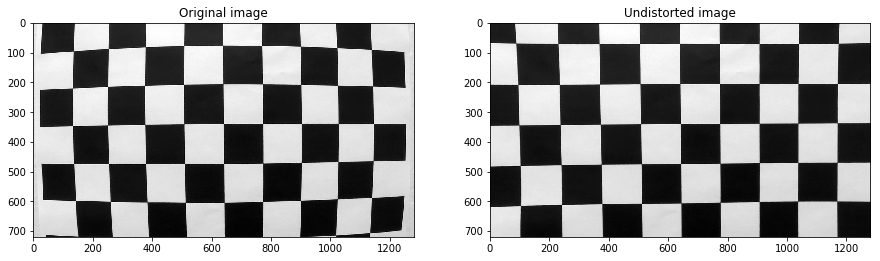

In [5]:
test_image = next(calibration_images())
processor = CorrectDistortion()
visualize_process_stage(test_image, processor(test_image), 
                        processed_title='Undistorted image',
                        orig_cmap='gray', processed_cmap='gray',
                        output_file='output/calibration_test.png')


# Image processing pipeline

In [6]:
sample_image = mpimg.imread('./test_images/test3.jpg')

## Correcting distortion

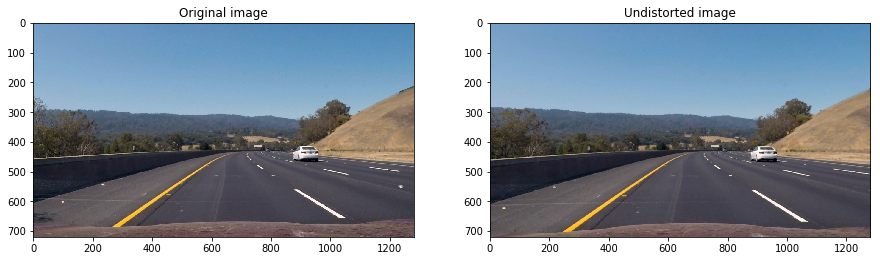

In [7]:
corrector = CorrectDistortion()
processed_image = corrector(sample_image)

visualize_process_stage(sample_image, processed_image, 
                        processed_title='Undistorted image', 
                        output_file='output/undistorted.png')

## Thresholding

In [8]:
class ExtractChannel(PipelineStage):
    def process(self, image):
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        return hsv[:, :, 2]
        

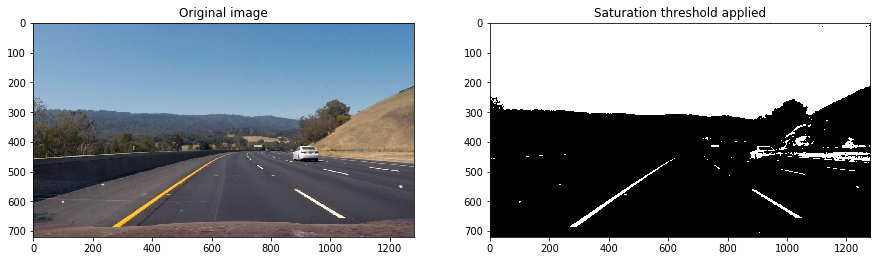

In [9]:
class ValueThreshold(PipelineStage):
    threshold = (180, 255)
    
    def process(self, image):
        mask = np.zeros_like(image)
        mask[(image > self.threshold[0]) & (image <= self.threshold[1])] = 1
        return mask
        

value_threshold = ExtractChannel(ValueThreshold())
processed = value_threshold(sample_image)
visualize_process_stage(sample_image, processed,
                        processed_title='Saturation threshold applied', 
                        processed_cmap='gray',
                        output_file='output/saturation_threshold.png')




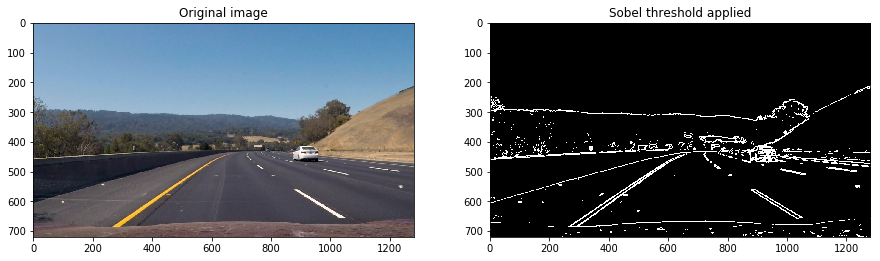

In [10]:
class SobelMagnitudeThreshold(PipelineStage):
    threshold = (30, 255)
    kernel = 5
    
    def process(self, image):
        sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=self.kernel)
        sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=self.kernel)
        sobel_mag = np.sqrt(np.square(sobel_x) + np.square(sobel_y))
        sobel_scaled = np.uint8(255 * sobel_mag / np.max(sobel_mag))
        mask = np.zeros_like(sobel_scaled)
        
        mask[(sobel_scaled > self.threshold[0]) & (sobel_scaled <= self.threshold[1])] = 1
        return mask
        

sobel_mag = ExtractChannel(SobelMagnitudeThreshold())
visualize_process_stage(sample_image, sobel_mag(sample_image),
                        processed_title='Sobel threshold applied', 
                        processed_cmap='gray',
                        output_file='output/sobel_threshold.png')

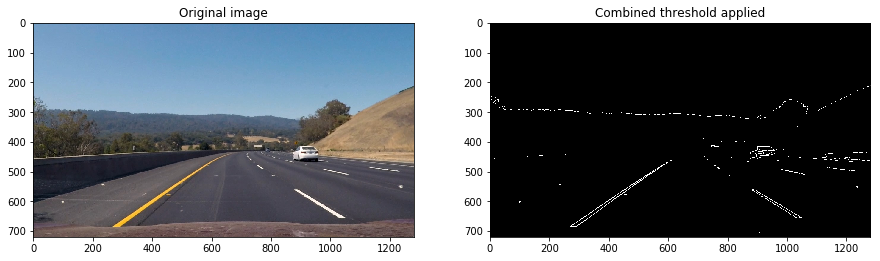

In [11]:
class And(PipelineStage):
    def __init__(self, t1, t2, next_stage=None):
        super().__init__(next_stage)
        self.t1 = t1
        self.t2 = t2
        
    def process(self, image):
        m1 = self.t1(image)
        m2 = self.t2(image)
        
        mask = np.zeros(image.shape[0:2])
        mask[(m1 == 1) & (m2 == 1)] = 1
        return mask
    
stage = ExtractChannel(And(ValueThreshold(), SobelMagnitudeThreshold()))

visualize_process_stage(sample_image, stage(sample_image),
                        processed_title='Combined threshold applied', 
                        processed_cmap='gray',
                        output_file='output/combined_threshold.png')

## Perspective transform

In [12]:
class PerspectiveTransform(PipelineStage):
    image_points = np.array([(245, 685), (580, 460), (704, 460), (1053, 667)], dtype=np.float32)
    object_points = np.array([(245, 720), (245, 0), (1053, 0), (1053, 720)], dtype=np.float32)
    warp_mtx = cv2.getPerspectiveTransform(image_points, object_points)
    unwarp_mtx = cv2.getPerspectiveTransform(object_points, image_points)
    
    def apply(self, image, mtx):
        img_size = (image.shape[1], image.shape[0])
        warped = cv2.warpPerspective(image, mtx, img_size, flags=cv2.INTER_LINEAR)
        return warped
    
class UnwarpPerspective(PerspectiveTransform):
    def process(self, image):
        return self.apply(image, self.warp_mtx)
    
class WarpPerspective(PerspectiveTransform):
    def process(self, image):
        return self.apply(image, self.unwarp_mtx)


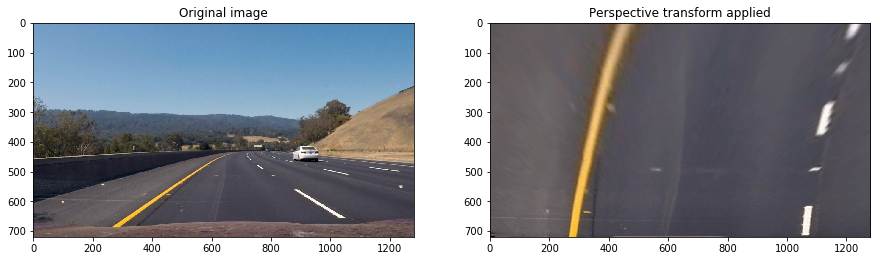

In [13]:
transform = UnwarpPerspective()

warped = transform(sample_image)
visualize_process_stage(sample_image, warped, processed_title='Perspective transform applied', 
                        output_file='output/perspective_transform.png')


## Finding lane lines

## Convolutional approach

In [14]:
class NoPeak(Exception):
    pass

class Convolver:
    window_width = 50
    window_height = 80
    margin = 100
    window = np.ones(window_width)
    
    def __init__(self, image):
        self.image = image
        self.image_width = image.shape[1]
        self.image_height = image.shape[0]
        self.prev = self.find_initial_centroids()
        
    def find_initial_centroids(self):
        lower_bound = self.image_height
        upper_bound = int(self.image_height / 2)
        pixels = self.image[upper_bound:lower_bound, :]
        pixel_sum = np.sum(pixels, axis=0)
        conv_signal = np.convolve(pixel_sum, self.window)    
        
        middle = len(conv_signal) // 2
        left_peak = self.find_peak(conv_signal[:middle]) - self.window_width // 2
        right_peak = self.find_peak(conv_signal[middle:]) + middle - self.window_width // 2
        return left_peak, right_peak
    
    def find_peak(self, array):
        peak = np.argmax(array)
        if peak == 0:
            raise NoPeak("No peak found", self.image)
        return peak
        
    def slice_image(self):
        layers = int(self.image_height / self.window_height)
        for layer in range(layers):
            lower_bound = self.image_height - (layer + 1) * self.window_height
            upper_bound = self.image_height - layer * self.window_height
            layer_pixels = self.image[lower_bound:upper_bound, :]
            yield ((lower_bound, upper_bound), layer_pixels)
            
    def convolve_by_layer(self):
        for bounds, layer in self.slice_image():
            layer_sum = np.sum(layer, axis=0)
            conv_signal = np.convolve(layer_sum, self.window)
            yield (bounds, conv_signal)
            
    def find_centroid(self, midpoint, signal):
        left = max(0, midpoint - self.margin)
        right = min(midpoint + self.margin, len(signal))
        search_area = signal[left:right]
        if (np.std(search_area) == 0):
            return midpoint
        else:
            centroid = np.argmax(search_area) + left - self.window_width // 2
            return centroid
    
    def find_centroids(self):
        centroids = []
        for bounds, signal in self.convolve_by_layer():
            left = self.find_centroid(self.prev[0], signal)
            right = self.find_centroid(self.prev[1], signal)
            centroids.append((bounds, left, right))
            self.prev = (left, right)
    
        return centroids


In [19]:
class FindLinePoints(PipelineStage):
    def process(self, image):
        self.conv = Convolver(image)
        centroids = self.conv.find_centroids()
        lines_img = np.zeros((image.shape[0], image.shape[1], 3), np.uint8)
        return self.map_centroids(lines_img, centroids)
    
    def map_centroids(self, image, centroids):
        points = []
        for bounds, left, right in centroids:
            center_y = bounds[0] + (bounds[1] - bounds[0]) // 2
            points.append(((left, center_y), (right, center_y)))
            
        return points

class DrawDetectedLines(PipelineStage):
    def process(self, points):
        lines_img = np.zeros((720, 1280, 3), np.uint8)
        for left, right in points:
            cv2.circle(lines_img, left, 10, (255, 0, 0), -1)
            cv2.circle(lines_img, right, 10, (255, 0, 0), -1)
        return lines_img
            


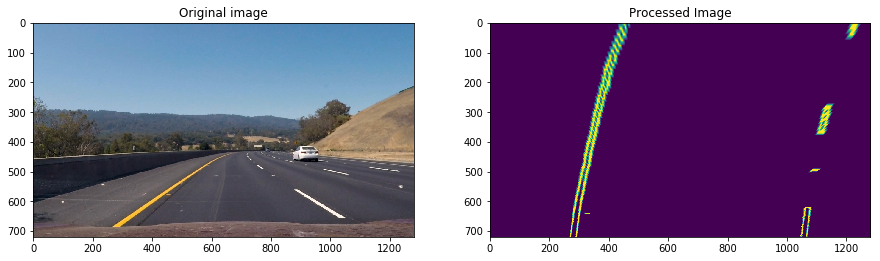

In [20]:
pipe = CorrectDistortion(
    ExtractChannel(And(SobelMagnitudeThreshold(), ValueThreshold(), UnwarpPerspective())))
processed = pipe(sample_image)

visualize_process_stage(sample_image, processed)


# Video processing pipeline

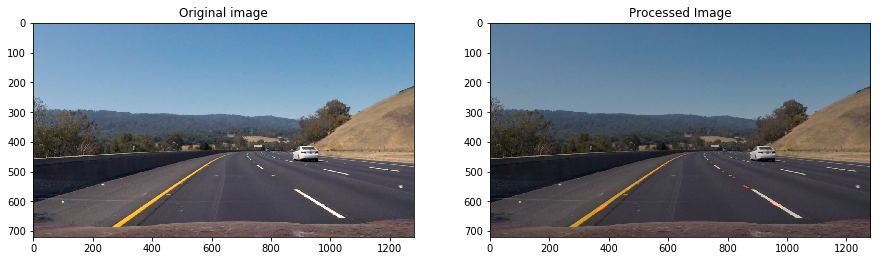

In [21]:
import os.path as path
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def display_video(video_file):
    return HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_file))

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def process_video(filename, processor):
    clip = VideoFileClip(filename)
    processed = clip.fl_image(processor)
    
    output_base = path.basename(filename)
    output_file = path.join('output', output_base)
    processed.write_videofile(output_file, audio=False)
    return output_file

def process_frame(line_detector):
    warp = WarpPerspective()
    
    def _fn(video_frame):
        try:
            lines_img = line_detector(video_frame)
            combined_image = weighted_img(warp(lines_img), video_frame)
            return combined_image
        except Exception as ex:
            raise Exception('Got an exception', video_frame, ex)
    
    return _fn

line_detector = process_frame(
    CorrectDistortion(ExtractChannel(
        And(SobelMagnitudeThreshold(), ValueThreshold(), 
              UnwarpPerspective(
                    FindLinePoints(DrawDetectedLines()))))))



sample_image = plt.imread('./test_images/test3.jpg')
visualize_process_stage(sample_image, line_detector(sample_image))

In [22]:
input_file = './project_video.mp4'
problem_frame = None
try:
    output = process_video(input_file, line_detector)
except Exception as ex:
    problem_frame = ex.args
    raise ex


[MoviePy] >>>> Building video output/project_video.mp4
[MoviePy] Writing video output/project_video.mp4


100%|█████████▉| 1260/1261 [02:10<00:00,  9.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/project_video.mp4 



In [23]:
display_video(output)

In [25]:
unwrapped = CorrectDistortion(ExtractChannel(
    And(SobelMagnitudeThreshold(), ValueThreshold(), 
          UnwarpPerspective())))

lines = FindLinePoints(DrawDetectedLines())
    
def processor(image):
    inter = unwrapped(image)
    lines_img = lines(inter)
    return weighted_img(lines_img, to_rgb(inter))
                              
    
output = process_video(input_file, processor)


[MoviePy] >>>> Building video output/project_video.mp4
[MoviePy] Writing video output/project_video.mp4


100%|█████████▉| 1260/1261 [02:12<00:00,  9.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/project_video.mp4 



In [26]:
display_video(output)


# Problem solving

In [ ]:
proc = ExtractChannel(And(ValueThreshold(), SobelMagnitudeThreshold(), UnwarpPerspective()))
processed = proc(image) 
plt.imshow(processed, 'gray')

In [ ]:
conv = Convolver(processed)

In [ ]:
centroids = []
for bounds, signal in conv.convolve_by_layer():
    left = conv.find_centroid(conv.prev[0], signal)
    right = conv.find_centroid(conv.prev[1], signal)
    centroids.append((bounds, left, right))
    conv.prev = (left, right)


In [ ]:
centroids

In [ ]:
left = conv.find_centroid(conv.prev[0], signal)


In [ ]:
conv.prev[0]

In [ ]:
max(0, 1)